In [1]:
from scipy.io import loadmat
import os
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import time
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statistics
from statistics import NormalDist
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from modules import BERT_Arch

In [2]:
imgpath = '/app/jupyter_space/sample-project/text_image_classifier/data/flowers102/images/'
txtpath = '/app/jupyter_space/sample-project/text_image_classifier/data/flowers102/text/'

modelpath = '/app/jupyter_space/sample-project/text_image_classifier/models'

device = torch.device("cuda")

max_seq_len = 100
pdist = nn.PairwiseDistance(p=2)

In [3]:
# load models
txtmodel = torch.load('./models/Text_Model_resnet34.pt')
imgmodel = torch.load('./models/Image_Model_resnet34.pt')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [4]:
input_text = "this flower is blue in color"

In [5]:
input_txt_token = tokenizer.batch_encode_plus([input_text], max_length = max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False)
input_seq = torch.tensor(input_txt_token['input_ids']).to("cuda")
input_mask = torch.tensor(input_txt_token['attention_mask']).to("cuda")
with torch.no_grad():
    input_txt_seq = txtmodel(input_seq, input_mask)
input_txt_seq.detach().cpu()
input_txt_seq.shape

/home/lawrenceliu/anaconda3/envs/deeplearning/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


torch.Size([1, 1000])

In [6]:
# load candidate images
image_files = []
img_tensors = []
count = 0
convert_tensor = transforms.ToTensor()
os.chdir(imgpath)
for _, _, filesname in os.walk(imgpath):
    for file in sorted(filesname):
        img = Image.open(file)
        img_tensors.extend([convert_tensor(img)])
        image_files.append(file)
        count += 1
        if count == 2000:
            break
    if count == 2000:
        break

# imaga data encode
img_tensors = torch.stack(img_tensors).to("cuda")


In [7]:
with torch.no_grad():
    imgout = imgmodel(img_tensors)
imgout.detach().cpu()
outimg = imgout

In [8]:
pairdist = torch.Tensor()
for image_id, img_code in enumerate(outimg):
    if len(pairdist) == 0:
        pairdist = torch.unsqueeze(pdist(img_code, input_txt_seq).sum(), 0)
    else:
        pairdist = torch.cat((pairdist, torch.unsqueeze(pdist(img_code, input_txt_seq).sum(), 0)))
pairdist

tensor([ 0.9169,  1.2547,  0.9514,  ...,  1.4946, 73.7321, 72.6834],
       device='cuda:0')

In [9]:
topk = 5
topkdist, topkindex = torch.topk(pairdist, k=topk, largest=False)
topkdist, topkindex

(tensor([0.6697, 0.6767, 0.6832, 0.6898, 0.6974], device='cuda:0'),
 tensor([1654, 1648,   74,  403,   89], device='cuda:0'))

In [10]:
cadidates_image_files = [image_files[_index] for _index in topkindex]
cadidates_image_files

['image_01655.jpg',
 'image_01649.jpg',
 'image_00075.jpg',
 'image_00404.jpg',
 'image_00090.jpg']

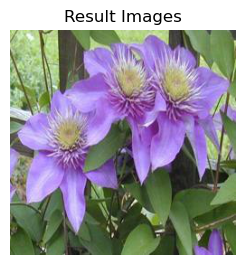

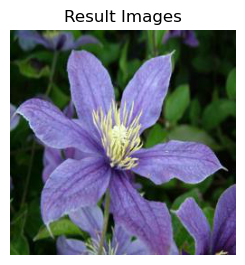

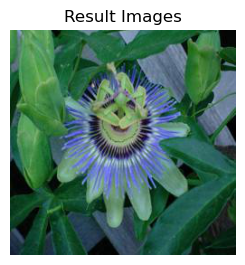

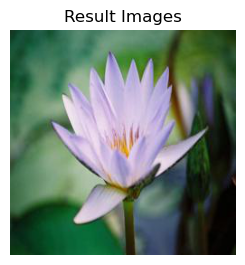

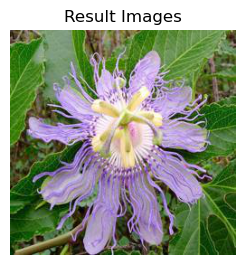

In [11]:
candidates = []
for filesname in cadidates_image_files:
    img = Image.open(filesname)
    candidates.extend([convert_tensor(img)])
for candidate in candidates:
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Result Images")
    plt.imshow(np.transpose(candidate,(1, 2, 0)))
    plt.show()